In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
import io
import torch.nn as nn
from scipy.optimize import curve_fit
from vast.opensetAlgos.openmax import fit_high
from scipy.stats import weibull_min, weibull_max
import umap
import umap.plot
import pandas as pd
import matplotlib.colors as mcolors

/home/dhuber/.conda/envs/umap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dhuber/.conda/envs/umap/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = ["../../Palatino/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
font_manager.get_font_names()

plt.rcParams["font.family"] = "Palatino"


In [4]:
def transpose(x):
    """Used for correcting rotation of EMNIST Letters"""
    return x.transpose(2, 1)

In [5]:
which_set = "train"
dataset_root = "../downloads/"
mnist = torchvision.datasets.EMNIST(
            root=dataset_root,
            train=which_set == "train",
            download=True,
            split="mnist",
            transform=transforms.Compose([transforms.ToTensor(), transpose]),
        )
letters = torchvision.datasets.EMNIST(
            root=dataset_root,
            train=which_set == "train",
            download=True,
            split="letters",
            transform=transforms.Compose([transforms.ToTensor(), transpose]),
        )

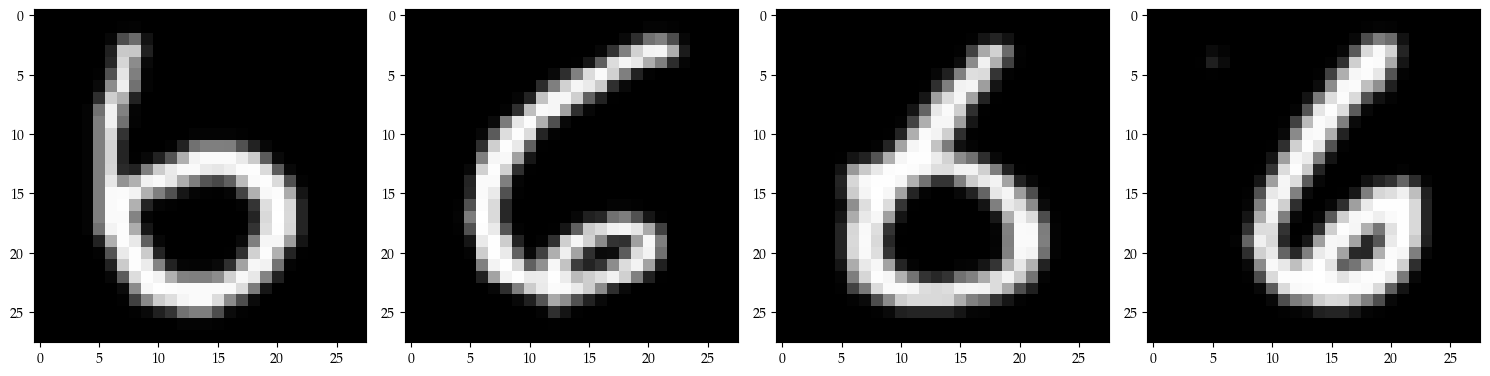

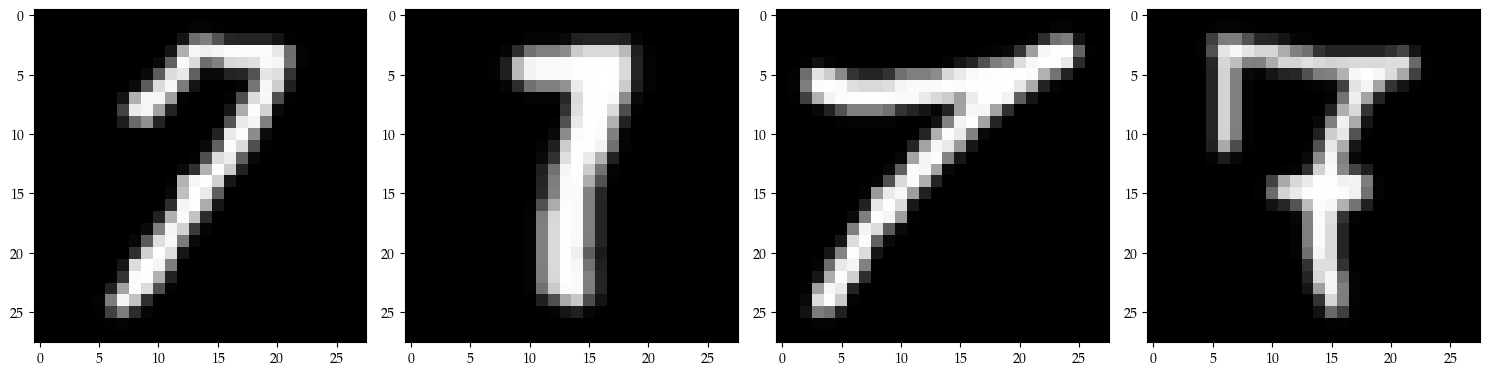

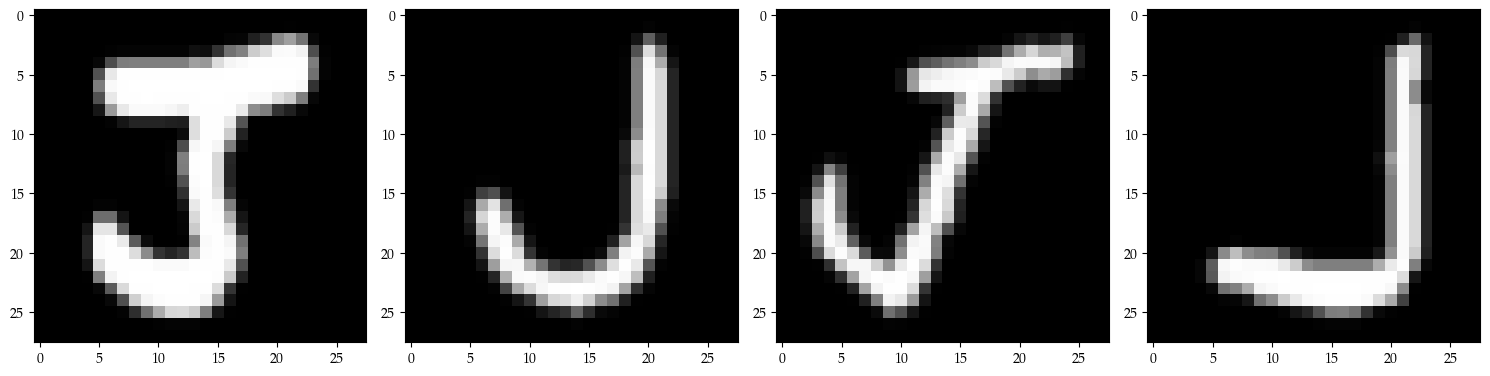

KeyboardInterrupt: 

In [6]:
cols = 4
rows = 1

def row_of_emnist(dataset, cols):
    fig, axs = plt.subplots(1, cols)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    targets_int = np.unique(dataset.targets)
    r_digit = np.random.randint(np.min(targets_int), np.max(targets_int) + 1)
    targets = np.array(dataset.targets)
    class_indices = np.where(targets == r_digit)[0]
    selected_elements = np.random.choice(class_indices, size=cols, replace=False)
    # fig.suptitle(f"Samples of {r_digit}")
    # fig.subplots_adjust(top=1.5)
    for idx, image_idx in enumerate(selected_elements):
        axs[idx].imshow(dataset[image_idx][0][0], cmap="gray")
    fig.tight_layout()
    actual = value = [i for i in dataset.class_to_idx if dataset.class_to_idx[i]==r_digit]
    plt.savefig(f"./output/emnist_row_{actual[0]}.png", bbox_inches='tight')

row_of_emnist(mnist, 4)
row_of_emnist(mnist, 4)
row_of_emnist(letters, 4)
row_of_emnist(letters, 4)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Define the three parameters for the Weibull distribution
shape = [2.0, 2.0, 3.0, 4.0] # This is 'k'
scale = [0.5, 1.0, 1.5, 3.0] # This is 'a'
location = 0.0 # This is 'c'



# Generate the plot
plt.figure(figsize=(8, 6))
for k, a in zip(shape, scale):
    # Generate a range of values for x
    x = np.linspace(weibull_max.ppf(0, k, loc=location, scale=a),
    weibull_max.ppf(0.99, k, loc=location, scale=a), 100)

    # Generate the y values for the probability density function
    y = weibull_max.cdf(x, k, loc=location, scale=a)
    plt.plot(x, y, lw=2, alpha=0.9, label=f'k = {k}, a = {a}')
plt.title('Weibull Distributions')
plt.xlabel('X')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.ylabel('Probability Density')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [ ]:
def load_network_output(path, model_name):
    file_ = path + "dnn_output_" + f"{model_name}" + ".pkl"
    with open(file_, "rb") as f:
        loaded_file = CPU_Unpickler(f).load()
        # loaded_file = pickle.load(f)
        return loaded_file

In [ ]:
def cosine_pairwisedistance(x, y):
    x = nn.functional.normalize(x, dim=1)
    y = nn.functional.normalize(y, dim=1)
    similarity = torch.einsum("nc,ck->nk", [x, y.T])
    distances = 1 - similarity
    return distances

In [ ]:
def euclidean_pairwisedistance(x, y):
    """
    Computes batched the p-norm distance between each pair of the two collections of row vectors.
    :param x: Tensor of size BxPxM
    :param y: Tensor of size BxRxM
    :returns: A Tensor of shape BxPxR
    """
    return torch.cdist(x, y, p=2, compute_mode="donot_use_mm_for_euclid_dist")

In [ ]:
def expo_func(x, a, b, c):
    return a * np.exp(-b * x) + c


In [ ]:
output = load_network_output("../saved_models/network_outputs/", "openmax_cnn_cifar0")
label_nr = 8
output_8 = output[0][label_nr]
output_unk = output[3][-1]
output_n = output[3][label_nr]
output_8.shape
output_n.shape

In [ ]:
features = output_8
mean_av_tensor = torch.mean(features, dim=0)
distances = cosine_pairwisedistance(features, mean_av_tensor[None, :])
tailsizes = [500, 1000]
distm = [1, 2]
w = {}
for t in tailsizes:
    for d in distm:
        weibull = fit_high(distances.T, d, t, translateAmount=1)
        w[f"{t}#{d}"] = weibull

distances = torch.flatten(distances).detach().numpy()


features_unk = output_unk
distance_unk = cosine_pairwisedistance(features_unk, mean_av_tensor[None, :])
distance_unk = torch.flatten(distance_unk).detach().numpy()
distance_unk = np.random.choice(distance_unk, size=1000, replace=False)

features_n = output_n
distance_n = cosine_pairwisedistance(features_n, mean_av_tensor[None, :])
distance_n = torch.flatten(distance_n).detach().numpy()

fig, ax1 = plt.subplots()

#ax1.hist(distances, color='lightgreen', density=True, alpha=0.7, ec='black', bins=30, label=f"known train")
ax1.hist(distance_unk, color='grey', density=False, alpha=0.7, ec='black', bins=30, label=f"unknowns")
ax1.hist(distance_n, color='lightgreen', density=False, alpha=0.6, ec='black', bins=30, label=f"knowns (digit: {label_nr})")

ax2 = ax1.twinx()

"""
for weibull in w:
    w_params = weibull.return_all_parameters()    
    # Define the shape and scale parameters for the Weibull distribution
    shape =  w_params["Shape"].detach().numpy() # Change this value according to your data
    scale =  w_params["Scale"].detach().numpy() # Change this value according to your data
    
    # Create a Weibull distribution
    weibull_dist = weibull_min(c=shape, scale=scale)
    
    # Generate x values
    x = np.linspace(weibull_dist.ppf(0.01), weibull_dist.ppf(0.99), 1000)
    test = np.array([1])

    print(f"Distance: {test[0]},\nCDF Score calc {weibull_dist.cdf(test)[0]},\nWSCORE = {1-weibull.wscore(torch.from_numpy(test), isReversed=True).item()}")
    
    # Calculate the corresponding y values
    y = weibull_dist.cdf(x)
    
    # Plot the Weibull distribution
    ax2.plot(x, y, 'r-', label='Weibull Distribution')
"""

for key, weibull in w.items():
    x = np.linspace(0.0, np.max(distance_unk), 100)
    y = weibull.wscore(torch.from_numpy(x), isReversed=True).detach().numpy()
    hypr = key.split("#")
    line = ax2.plot(x, y.flatten(), label=f"$\eta$: {hypr[0]}, $\kappa$: {hypr[1]}")

# Get the handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine the handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

ax1.legend(handles, labels)
ax1.set_ylabel("Frequency")
ax2.set_ylabel("Probability")
ax1.set_xlabel("Cosine distance")
ax1.set_title(f"Distances between known and unknown samples to the MAV belonging to the known class with Probabilities")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.savefig("distances-to-mav.png",  dpi=400)

In [ ]:
plt.show()

In [ ]:
distances = euclidean_pairwisedistance(features, mean_av_tensor[None, :])
distances = torch.flatten(distances).detach().numpy()

distance_unk = euclidean_pairwisedistance(features_unk, mean_av_tensor[None, :])
distance_unk = torch.flatten(distance_unk).detach().numpy()
distance_unk = np.random.choice(distance_unk, size=1000, replace=False)

plt.hist(distances, color='lightgreen', ec='black', bins=30)
plt.hist(distance_unk, color='grey', alpha=0.7, ec='black', bins=30)

plt.show()

In [ ]:
#output = load_network_output("../saved_models/network_outputs/", "openmax_cnn_cifar0")
output = load_network_output("../saved_models/network_outputs/", "openmax_cnn_emnist_cluster-30_umap")

In [ ]:
colors = [[0, 0, 0, 1],
 [0, 0, 0, 1],
 [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
 [8.33333333e-01, 8.66025404e-01, 5.00000000e-01, 1.00000000e+00],
 [1.00000000e+00, 2.55842778e-01, 1.28999217e-01, 1.00000000e+00],
 [1.96078431e-03, 7.09281308e-01, 9.23289106e-01, 1.00000000e+00],
 [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00],
 [5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
 [1.70588235e-01, 4.94655843e-01, 9.66718404e-01, 1.00000000e+00],
 [6.68627451e-01, 9.65124085e-01, 6.07538946e-01, 1.00000000e+00],
 [1.00000000e+00, 4.94655843e-01, 2.55842778e-01, 1.00000000e+00],
 [1.00000000e+00, 7.00543038e-01, 3.78411050e-01, 1.00000000e+00],
 ]
colors_emnist = np.array(colors)


In [ ]:
def prepare_data(train, test, unknowns=False, mavs=True):
    labels = []
    data = []
    for key, value in test.items():
        if key != -1 or unknowns:
            labels.extend([key]*len(value))
            data.extend(value.detach().numpy())
    if mavs:  
        for key, value in train.items():
            mav = torch.mean(value, dim=0)
            mav = torch.reshape(mav, (1, mav.shape[0]))
            data.extend(mav.detach().numpy())
            labels.extend([-2])
        
    labels = np.array(labels)
    data = np.array(data)
    return data, labels

In [ ]:
def plot_setup(mapper, n_labels):
    colors = plt.cm.rainbow(np.linspace(0, 1, n_labels+1))
    np.random.shuffle(colors)
    colors[-1] = colors[0]
    colors[0] = [0, 0, 0, 1]  # RGBA color for black
    
    colormap = mcolors.ListedColormap(colors_emnist[1:])
    label_mask = labels == -2
    coord_mav = mapper.embedding_[label_mask]
    return colormap, coord_mav, colors

In [ ]:
def plot_with_mav(mapper,coord_mav, colormap, labels, colors):
    ax = umap.plot.points(mapper, labels=labels, color_key_cmap=colormap)
    ax.scatter(coord_mav[:,0], coord_mav[:,1], color='red', marker='*', s=70, ec='black', label='MAV', linewidth=0.5)
    ax.set_title("UMAP projection of known test samples from CIFAR-10 with MAV")
    ax.set_xlabel("UMAP 1")
    ax.set_xlim()
    ax.set_ylabel("UMAP 2")
    
    # Define the labels and colors
    labels = np.unique(labels)
    colors = colors

    # Create a list of legend handles
    handles = [plt.scatter([], [], color=color, linestyle='None') for color in colors]
    handles[0] = plt.scatter([], [], marker='*', ec='black', color='red', linestyle='None', linewidth=0.5)
    labels = labels.astype(str)
    labels[0] = "MAV"

    # Create a new legend
    ax.legend(handles, labels, loc="upper left")
    plt.savefig("output/umap_projection_emnist_cluster_input.png", dpi=800)
    plt.show()

In [ ]:
data, labels = prepare_data(output[0], output[3])
mapper = umap.UMAP().fit(data)
colormap, coord_mav, colors = plot_setup(mapper, len(set(labels)))
plot_with_mav(mapper, coord_mav, colormap, labels, colors)

In [ ]:
def plot_setup0(mapper, n_labels):
    colors = plt.cm.rainbow(np.linspace(0, 1, 5))
    #np.random.shuffle(colors)
    #colors[-1] = colors[0]
    #colors[0]
    colors = np.delete(colors, 3, 0)
    colors = np.delete(colors, 3, 0)
    black = np.array([[0, 0, 0, 1]])  # RGBA color for black
    colors =  np.tile(colors,(10,1))
    colors = np.concatenate((black, colors))
    
    colormap = mcolors.ListedColormap(colors)
    label_mask = labels == -2
    coord_mav = mapper.embedding_[label_mask]
    return colormap, coord_mav, colors

In [ ]:
def plot_with_mav0(mapper,coord_mav, colormap, labels, colors):
    ax = umap.plot.points(mapper, labels=labels, color_key_cmap=colormap)
    ax.scatter(coord_mav[:,0], coord_mav[:,1], color='red', marker='*', s=70, ec='black', label='MAV', linewidth=0.5)
    ax.set_title("UMAP projection of validation feature agglomerative clustering with MAV")
    ax.set_xlabel("UMAP 1")
    ax.set_xlim()
    ax.set_ylabel("UMAP 2")
    
    # Define the labels and colors
    labels = np.unique(labels)
    colors = colors

    # Create a list of legend handles
    handles = [plt.scatter([], [], color=color, linestyle='None') for color in colors]
    handles[0] = plt.scatter([], [], marker='*', ec='black', color='red', linestyle='None', linewidth=0.5)
    labels = labels.astype(str)[:4]
    labels = [f"Cluster {x} of Class c" for x in range(4)]
    labels[0] = "MAV"
    # Create a new legend
    ax.legend(handles, labels, loc="upper left")
    plt.savefig("output/umap_projection_cifar_cluster.png", dpi=800)
    plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering


def agglo_clustering(n_clusters_, linkage_, metric_, clustering_data):
    clusterer_agglo = AgglomerativeClustering(
        n_clusters=n_clusters_, linkage=linkage_, metric=metric_
    )
    clusterer_agglo.fit_predict(clustering_data)
    return clusterer_agglo

In [ ]:
def val_features_clustering(features, num_cluster_pro_class):
    cluster_features_dict = {}
    for key in features.keys():
        clusterer = agglo_clustering(
            num_cluster_pro_class, "ward", "euclidean", features[key].detach().numpy()
        )
        for cluster_label, values in zip(clusterer.labels_, features[key]):
            dict_key_cluster = key * num_cluster_pro_class + cluster_label
            if dict_key_cluster in cluster_features_dict:
                cluster_features_dict[dict_key_cluster] = torch.cat(
                    (cluster_features_dict[dict_key_cluster], values[None, :])
                )
            else:
                cluster_features_dict[dict_key_cluster] = values[None, :]
    return cluster_features_dict

In [ ]:
cluster_features = val_features_clustering(output[1], 3)
cluster_features.keys()

In [ ]:
data, labels = prepare_data(cluster_features, cluster_features)
mapper = umap.UMAP().fit(data)
colormap, coord_mav, colors = plot_setup0(mapper,len(set(labels)))
plot_with_mav0(mapper, coord_mav, colormap, labels, colors)

In [ ]:
def plot_setup1(mapper, n_labels):
    colors = plt.cm.rainbow(np.linspace(0, 1, n_labels))
    np.random.shuffle(colors)
    colors[-1] = colors[0]
    print(colors)
    colors[1] = [0, 0, 0, 1]  # RGBA color for black
    
    colormap = mcolors.ListedColormap(colors_emnist)
    label_mask = labels == -2
    coord_mav = mapper.embedding_[label_mask]
    return colormap, coord_mav, colors

In [ ]:
def plot_with_mav1(mapper,coord_mav, colormap, labels, colors):
    ax = umap.plot.points(mapper, labels=labels, color_key_cmap=colormap)
    ax.scatter(coord_mav[:,0], coord_mav[:,1], color='white', marker='', s=70, ec='black', label='MAV', linewidth=0.5)
    ax.set_title("UMAP projection of known and unknown test samples")
    ax.set_xlabel("UMAP 1")
    ax.set_xlim()
    ax.set_ylabel("UMAP 2")
    
    # Define the labels and colors
    labels = np.unique(labels)
    colors = colors

    # Create a list of legend handles
    handles = [plt.scatter([], [], color=color, linestyle='None') for color in colors]
    #handles[0] = plt.scatter([], [], marker='*', ec='black', color='red', linestyle='None', linewidth=0.5)
    labels = labels.astype(str)
    #labels[0] = "MAV"
    labels[1] = "unknowns"

    # Create a new legend
    ax.legend(handles[1:], labels[1:])
    plt.savefig("output/umap_projection_cifar_unknowns.png", dpi=800)
    plt.show()

In [ ]:
data, labels = prepare_data(output[0], output[3], True, True)
mapper = umap.UMAP().fit(data)
colormap, coord_mav, colors = plot_setup1(mapper,len(set(labels)))
plot_with_mav1(mapper, coord_mav, colormap, labels, colors)